# Experiment 2 Notebook

In this experiment we build a machine learning model around the diabetes_v2 csv file. In this version of the dataset we have imputed the records with missing data and we have eliminated the outliers. With this approach we kept most of the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from helpers import MultiplePlotMaker, StatAnalysisTools, ModelEvaluation
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('dataset/diabetes_v2.csv').drop(columns=['index'])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5,116.0,74.0,24.2,85.0,25.6,0.201,30,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               665 non-null    int64  
 1   Glucose                   665 non-null    float64
 2   BloodPressure             665 non-null    float64
 3   SkinThickness             665 non-null    float64
 4   Insulin                   665 non-null    float64
 5   BMI                       665 non-null    float64
 6   DiabetesPedigreeFunction  665 non-null    float64
 7   Age                       665 non-null    int64  
 8   Outcome                   665 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 46.9 KB


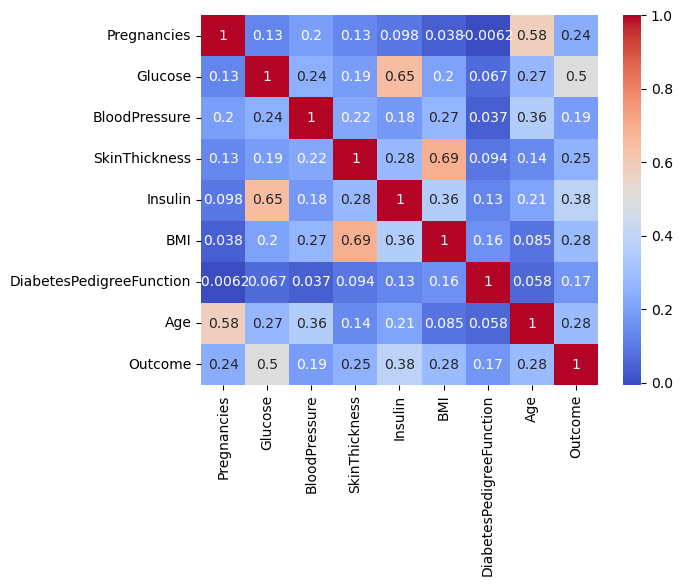

In [5]:
# Correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

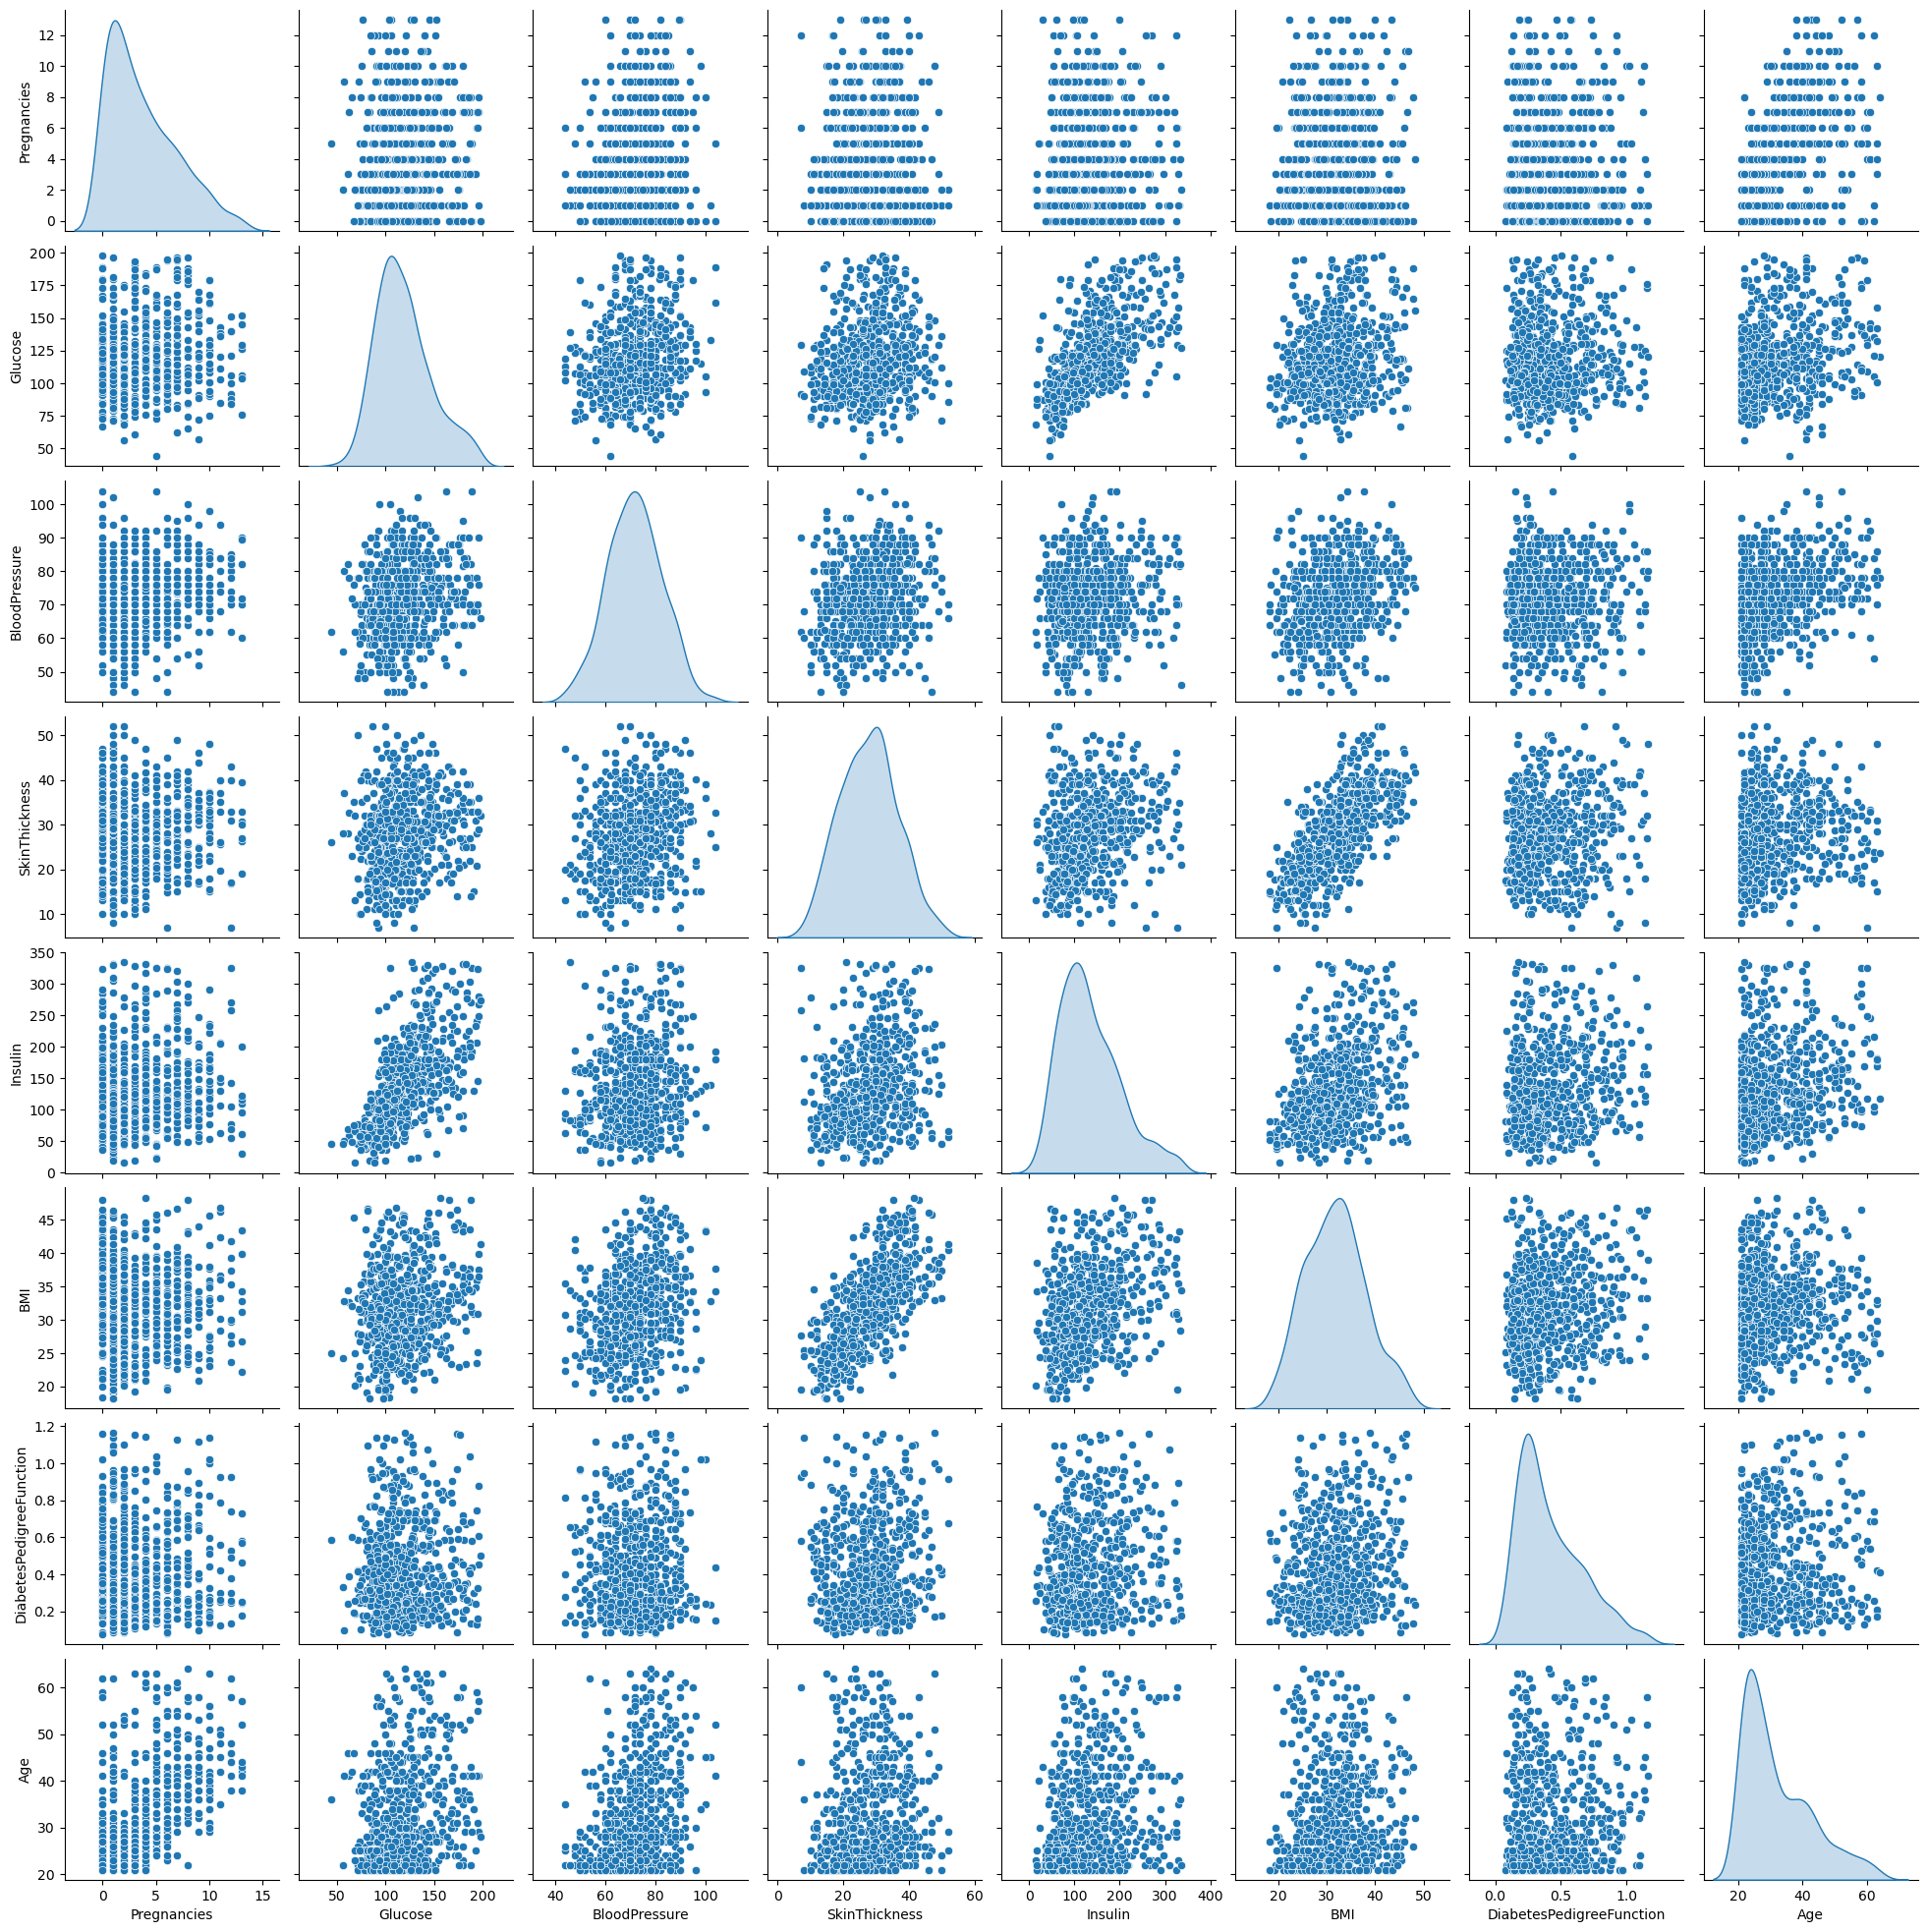

In [6]:
# List of columns to compare pairwise
columns_to_compare = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                      'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create pairplot
sns.pairplot(df[columns_to_compare], diag_kind='kde')  # kde gives smoother diagonal plots

plt.show()

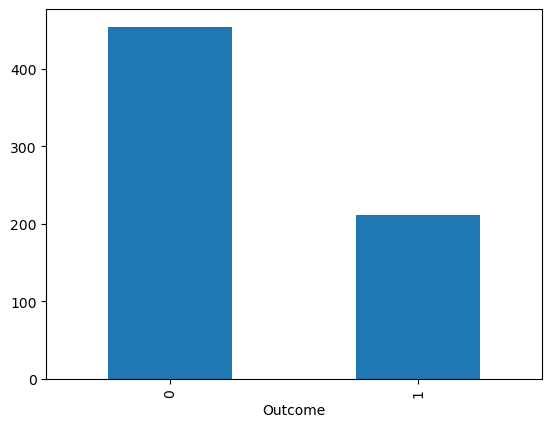

In [7]:
# Showing the class imbalance in our targer variable
df['Outcome'].value_counts().plot(kind='bar')
plt.show()


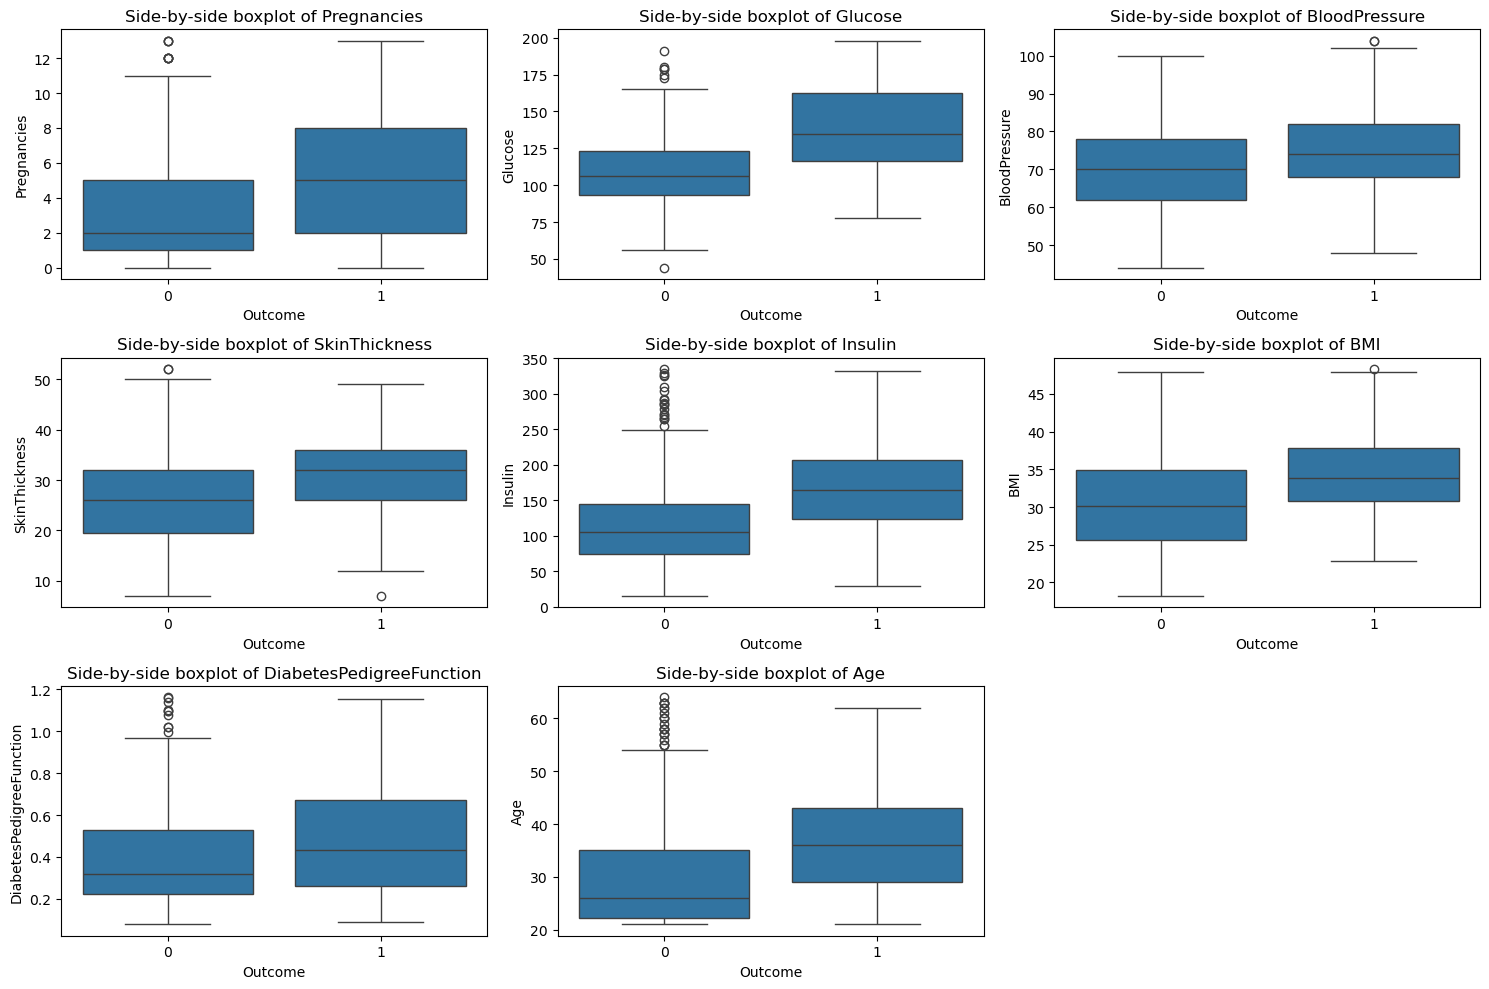

In [8]:
# Side by side boxplots to analyze associations between people with diabetes and wihtout diabetes
make_plots = MultiplePlotMaker(df=df)
make_plots.plot_multiple_side_by_side_boxplots()


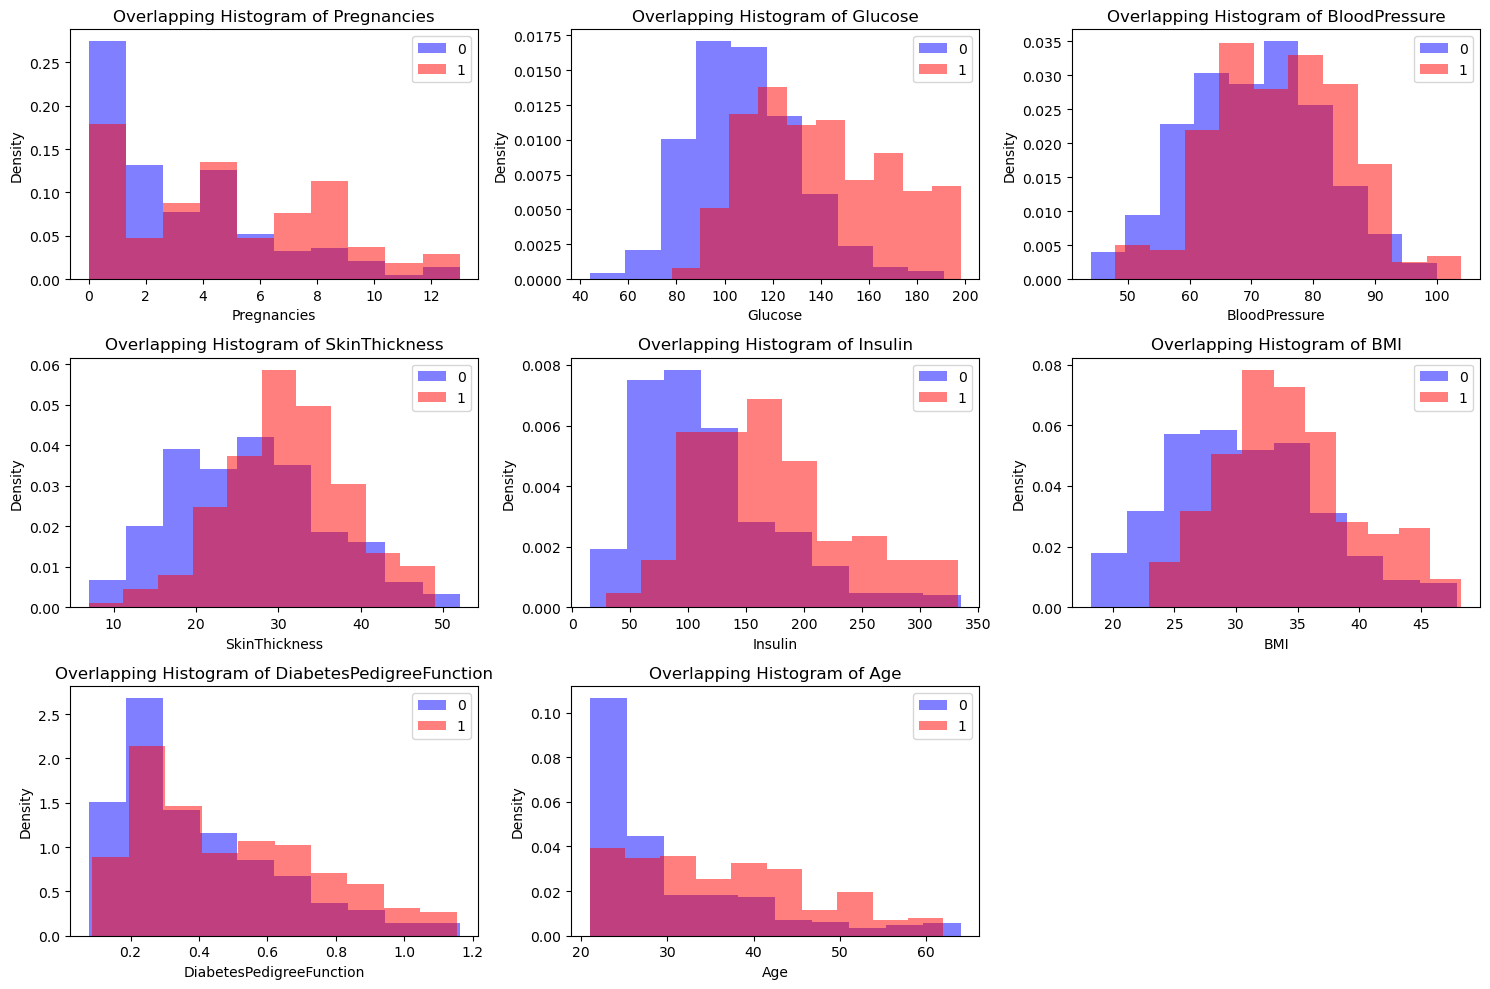

In [9]:
# Overlapping histograms to analyze associations between people with diabetes and wihtout diabetes
make_plots.plot_multiple_overlapping_hist()

In [10]:
# Perform numeric analysis to assess feature importance
stat_analysis = StatAnalysisTools(df=df)
stat_analysis.perform_t_test()

Pregnancies: t_stat = -6.273443205927671,  p-value = 6.373581530650901e-10
Glucose: t_stat = -14.84045443315977,  p-value = 3.1437778332365067e-43
BloodPressure: t_stat = -4.925186687782909,  p-value = 1.0653133230201263e-06
SkinThickness: t_stat = -6.669510587094986,  p-value = 5.414356003023468e-11
Insulin: t_stat = -10.687148682346534,  p-value = 1.0496023075901367e-24
BMI: t_stat = -7.532906663368255,  p-value = 1.630787911935224e-13
DiabetesPedigreeFunction: t_stat = -4.471715252396757,  p-value = 9.127682379822721e-06
Age: t_stat = -7.609233983888491,  p-value = 9.495331198241036e-14


In [11]:
stat_analysis.perform_correlation_binary_target()

Pregnancies: correlation = 0.23671582610290237, p-value = 6.373581530650703e-10
Glucose: correlation = 0.49935345549999016, p-value = 3.14377783323613e-43
BloodPressure: correlation = 0.18787239178663823, p-value = 1.065313323020082e-06
SkinThickness: correlation = 0.25074723621062667, p-value = 5.4143560030233716e-11
Insulin: correlation = 0.38334625378661735, p-value = 1.0496023075901233e-24
BMI: correlation = 0.2807846446700808, p-value = 1.6307879119352678e-13
DiabetesPedigreeFunction: correlation = 0.17110590018344107, p-value = 9.127682379822889e-06
Age: correlation = 0.2834022494234941, p-value = 9.495331198241284e-14


### Feature Importance / Association with Target Variable

#### Very Strong Association
- Glucose
- Insuline
- Age

#### Moderate to Strong Association
- Pregnancies
- SkinThickness
- BMI

#### Weak Association
- BloodPressure
- DiabetesPedigreeFunction

#### Comments
We can train the model with all the features and then eliminate the ones with weak associaitons and see if the model performance is the same or better.

## Data Preprocessing

In [45]:
y = df['Outcome']
# X = df.drop(columns='Outcome')
X = df.drop(columns=['Outcome', 'BloodPressure', 'DiabetesPedigreeFunction'])


# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


scaler_type = StandardScaler()


# Metadata for results csv
selected_features = 'without BP and DPF'
scaler_name = 'StandardScaler'
results_file_path = 'experiment_results/experiment_2.csv'

In [46]:
estimator_pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', KNeighborsClassifier())
    ]),
    'Random Forest': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scorer = make_scorer(f1_score)

for estimetor_name, estimator_pipeline in estimator_pipelines.items():
    scores = cross_val_score(estimator_pipeline, X_train, y_train, scoring=scorer, cv=cv)
    print(f'{estimetor_name} F1-score: {scores.mean():.3f} ± {scores.std():.3f}')

Logistic Regression F1-score: 0.639 ± 0.060
KNN F1-score: 0.647 ± 0.042
Random Forest F1-score: 0.607 ± 0.053


In [47]:
# Hyperparameter Tunning to check if we can get higher F1 scores

# Logistic Regression hyperparameters
logreg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'l1'],  # Note: 'l1' is supported only by 'liblinear' and 'saga'
    'classifier__solver': ['liblinear', 'saga']
}

# KNN hyperparameters
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Random Forest hyperparameters
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# GridSearchCV for Logistic Regression
logreg_grid_search = GridSearchCV(
    estimator_pipelines['Logistic Regression'], 
    param_grid=logreg_param_grid, 
    cv=cv, 
    scoring=scorer,
    n_jobs=-1
)

# GridSearchCV for KNN
knn_grid_search = GridSearchCV(
    estimator_pipelines['KNN'], 
    param_grid=knn_param_grid, 
    cv=cv, 
    scoring=scorer,
    n_jobs=-1
)

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator_pipelines['Random Forest'], 
    param_grid=rf_param_grid, 
    cv=cv, 
    scoring=scorer,
    n_jobs=-1
)

In [48]:
model_evaluation = ModelEvaluation()

In [49]:
# Run GridSearchCV for KNN
knn_grid_search.fit(X_train, y_train)
print(f"Best KNN parameters: {knn_grid_search.best_params_}")
print(f"Best KNN F1-score: {knn_grid_search.best_score_:.3f}")
print('=' * 20)

Best KNN parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Best KNN F1-score: 0.650


In [50]:
# Run GridSearchCV for Random Forest
rf_grid_search.fit(X_train, y_train)
print(f"Best RF parameters: {rf_grid_search.best_params_}")
print(f"Best RF F1-score: {rf_grid_search.best_score_:.3f}")
print('=' * 20)

Best RF parameters: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best RF F1-score: 0.664


In [51]:
# Run GridSearchCV for Logistic Regression
logreg_grid_search.fit(X_train, y_train)
print(f"Best Logistic Regression parameters: {logreg_grid_search.best_params_}")
print(f"Best Logistic Regression F1-score: {logreg_grid_search.best_score_:.3f}")
print('=' * 20)

Best Logistic Regression parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Logistic Regression F1-score: 0.640


Accuracy: 0.722
Precision: 0.540
Recall: 0.810
F1-Score: 0.648
ROC-AUC Score: 0.805
Confusion Matrix:
[[62 29]
 [ 8 34]]


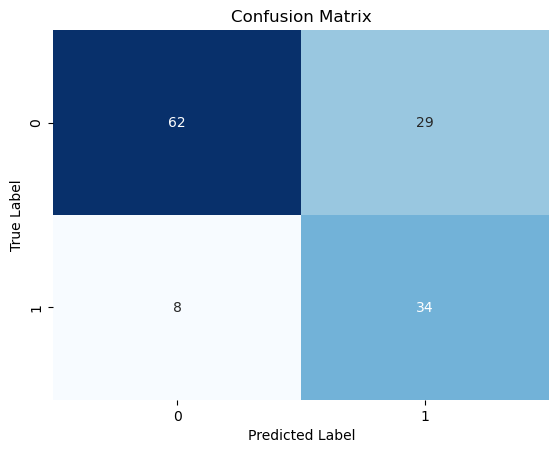

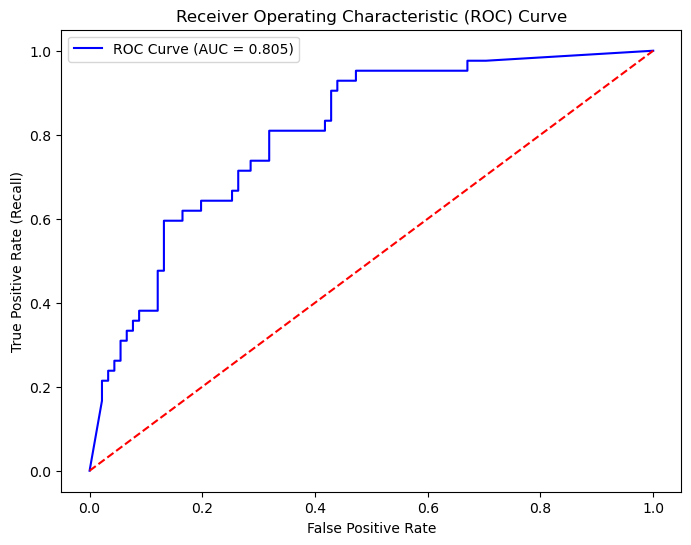

In [52]:
model_evaluation.evaluate_classifier(X_test, y_test, knn_grid_search.best_estimator_, model_name='KNN', scaler_name=scaler_name, selected_features=selected_features, csv_file_path=results_file_path)

Accuracy: 0.789
Precision: 0.646
Recall: 0.738
F1-Score: 0.689
ROC-AUC Score: 0.897
Confusion Matrix:
[[74 17]
 [11 31]]


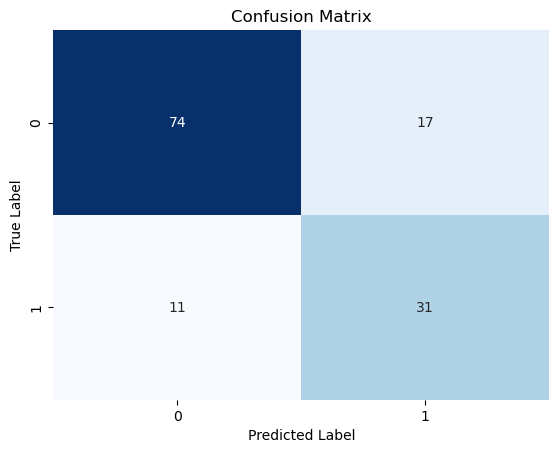

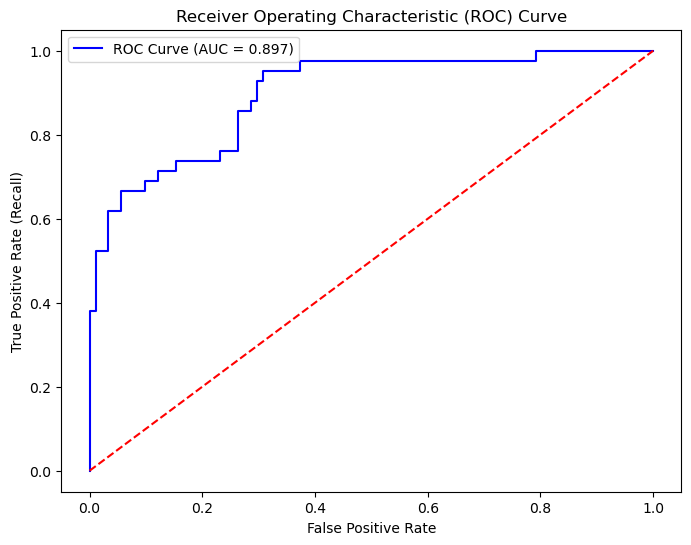

In [53]:
model_evaluation.evaluate_classifier(X_test, y_test, rf_grid_search.best_estimator_, model_name='RandomForest', scaler_name=scaler_name, selected_features=selected_features, csv_file_path=results_file_path)

Accuracy: 0.729
Precision: 0.554
Recall: 0.738
F1-Score: 0.633
ROC-AUC Score: 0.859
Confusion Matrix:
[[66 25]
 [11 31]]


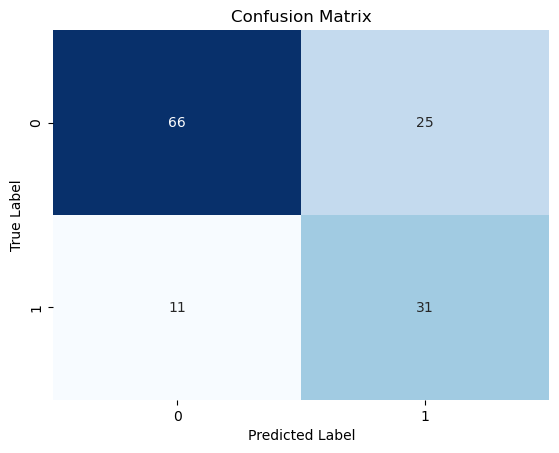

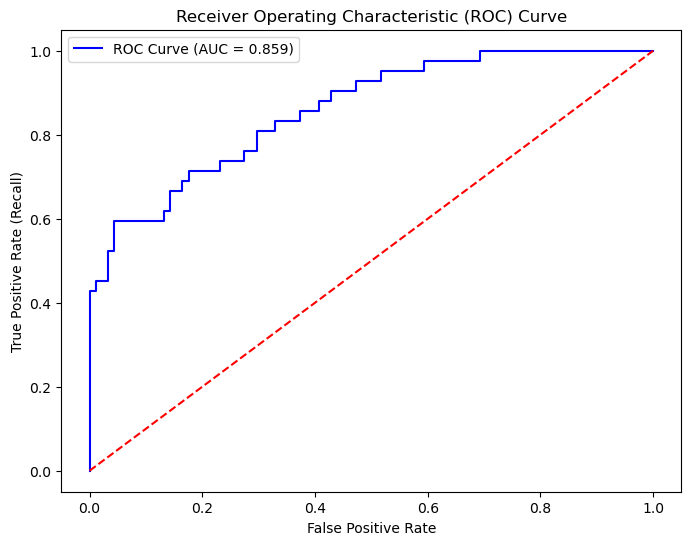

In [54]:
model_evaluation.evaluate_classifier(X_test, y_test, logreg_grid_search.best_estimator_, model_name='LogReg', scaler_name=scaler_name, selected_features=selected_features, csv_file_path=results_file_path)

In [55]:
# Results
results_df = pd.read_csv('experiment_results/experiment_2.csv')
results_df.sort_values(by='f1_score', ascending=False)

,model_name,scaler_name,selected_features,accuracy,precision,recall,f1_score,roc_auc
1,RandomForest,StandardScaler,all features,0.804511,0.666667,0.761905,0.711111,0.881737
0,KNN,StandardScaler,all features,0.759398,0.580645,0.857143,0.692308,0.857012
10,RandomForest,StandardScaler,without BP and DPF,0.789474,0.645833,0.738095,0.688889,0.897174
4,RandomForest,RobustScaler,all features,0.781955,0.632653,0.738095,0.681319,0.881868
5,LogReg,RobustScaler,all features,0.766917,0.600000,0.785714,0.680412,0.841183
7,RandomForest,RobustScaler,without BP and DPF,0.774436,0.620000,0.738095,0.673913,0.881476
2,LogReg,StandardScaler,all features,0.751880,0.578947,0.785714,0.666667,0.850602
3,KNN,RobustScaler,all features,0.736842,0.555556,0.833333,0.666667,0.816981
8,LogReg,RobustScaler,without BP and DPF,0.736842,0.555556,0.833333,0.666667,0.869178
6,KNN,RobustScaler,without BP and DPF,0.729323,0.546875,0.833333,0.660377,0.812140
